In [1]:
import os, sys
import numpy as np
from sklearn.model_selection import train_test_split
from tqdm.notebook import tqdm
import cv2
import torch
from torchvision.models import alexnet, vgg19, inception_v3, resnet50
import timm
from torch.utils.data import Dataset, DataLoader
from thop import profile
from tool import trainer, imageDataset
import matplotlib.pyplot as plt
torch.__version__

'2.0.0+cu117'

In [2]:
RANDOM_STATE = 111
BATCH_SIZE = 1
EPOCHS = 10
LR = 1e-4
TEST_SIZE = 0.15

### 讀取資料

In [3]:
dir_path = './data/'
dir_list = ['normal', 'osteopenia', 'osteoporosis']

data_path, labels = [], []
for index, item in enumerate(dir_list):
    images = os.listdir(dir_path + item)
    for image in images:
        if image[0] != '.':
            data_path.append(dir_path + item + '/' + image)
            labels.append(index)

print(f'資料共{len(data_path)}筆')

資料共239筆


### 資料前處理

In [4]:
def data_preprocess(paths):
    features = []
    for path in tqdm(paths):
        # 讀取image，並轉為灰階影像
        img = cv2.imread(path)
        img = cv2.resize(img, (224, 224))
        img = np.transpose(img, (2, 0, 1)).astype('float32')
        # 標準化(MaxAbs)，灰階影像最大為255
        img = img / 255
        features.append(img)
        
    return features

### OneHotEncoding

In [5]:
# 轉成np.array再轉成oneHotEncoding
def OneHotEncoding(labels):
    y = np.eye(3)[np.array(list(map(int, labels)))]
    return y

### 切分資料

In [6]:
%%time
X_train, X_valid, Y_train, Y_valid = train_test_split(data_path, labels, test_size=TEST_SIZE, random_state=RANDOM_STATE)
print(f'訓練資料共{len(X_train)}筆')
print(f'驗證資料共{len(X_valid)}筆')

訓練資料共203筆
驗證資料共36筆
CPU times: user 825 µs, sys: 0 ns, total: 825 µs
Wall time: 741 µs


### Data Preocess and set DataLoader

In [7]:
%%time
train_data = imageDataset(data_preprocess(X_train), OneHotEncoding(Y_train))
val_data = imageDataset(data_preprocess(X_valid), OneHotEncoding(Y_valid))

# set device
device = 'cuda:0' if torch.cuda.is_available() else 'cpu'
# set the DataLoader
train_loader = DataLoader(train_data, batch_size=BATCH_SIZE, shuffle = True)
test_loader = DataLoader(val_data, batch_size=36, shuffle = False)

  0%|          | 0/203 [00:00<?, ?it/s]

  0%|          | 0/36 [00:00<?, ?it/s]

CPU times: user 5.29 s, sys: 350 ms, total: 5.64 s
Wall time: 5.65 s


In [8]:
!nvidia-smi

Sat Jun 10 03:52:26 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 515.57       Driver Version: 515.57       CUDA Version: 11.7     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA GeForce ...  Off  | 00000000:06:00.0  On |                  N/A |
| 26%   52C    P3    38W / 125W |   1225MiB /  6144MiB |     35%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

# 各模型比較

In [9]:
input,output = next(iter(train_loader))
print(input.shape)
print(output)
input = input.to(device)
output = output.to(device)

torch.Size([1, 3, 224, 224])
tensor([[0., 1., 0.]], dtype=torch.float64)


In [10]:
from sklearn.preprocessing import normalize

In [11]:
!nvidia-smi

Sat Jun 10 03:52:27 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 515.57       Driver Version: 515.57       CUDA Version: 11.7     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA GeForce ...  Off  | 00000000:06:00.0  On |                  N/A |
| 26%   53C    P2    43W / 125W |   1658MiB /  6144MiB |     36%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

### alexnet
- https://pytorch.org/vision/0.11/models.html?highlight=alexnet#torchvision.models.alexnet

/home/yancheng/miniconda3/envs/DL/lib/python3.8/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/yancheng/miniconda3/envs/DL/lib/python3.8/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


--------------------Epoch 1--------------------
Train_accuracy: 63.55% | Train_loss: 191.0717
--------------------Epoch 2--------------------
Train_accuracy: 63.55% | Train_loss: 177.9949
--------------------Epoch 3--------------------
Train_accuracy: 66.50% | Train_loss: 176.7786
--------------------Epoch 4--------------------
Train_accuracy: 63.55% | Train_loss: 165.6004
--------------------Epoch 5--------------------
Train_accuracy: 66.50% | Train_loss: 163.2286
--------------------Epoch 6--------------------
Train_accuracy: 67.98% | Train_loss: 149.9484
--------------------Epoch 7--------------------
Train_accuracy: 72.41% | Train_loss: 142.4355
--------------------Epoch 8--------------------
Train_accuracy: 72.41% | Train_loss: 128.6590
--------------------Epoch 9--------------------
Train_accuracy: 72.41% | Train_loss: 126.8530
--------------------Epoch 10--------------------
Train_accuracy: 78.82% | Train_loss: 105.3877


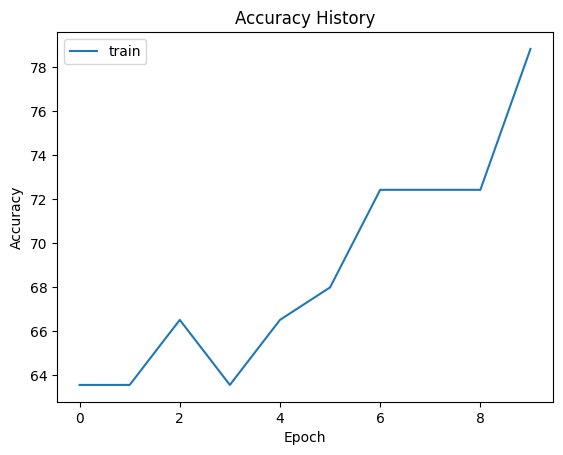

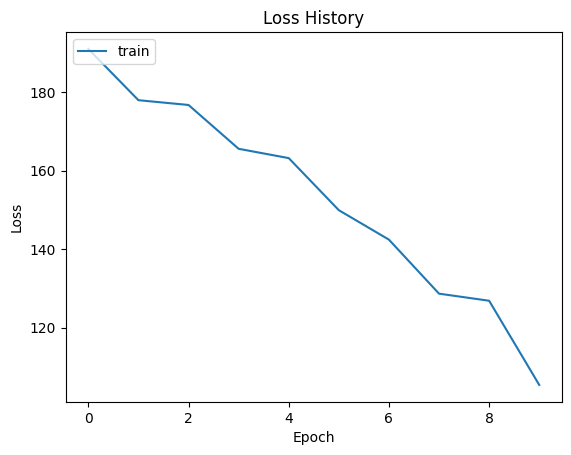

Accuracy on the test images: 58.33%
Inference time: 14.5034 milliseconds


In [12]:
# pre-trained model(https://pytorch.org/vision/0.11/models.html?highlight=alexnet#torchvision.models.alexnet)
model = alexnet(pretrained=True).to(device)
# Modify the last layer(num_classes: 1000 => 3), Replace the last layer with a new fully connected layer with 3 output units(ChatGPT)
model.classifier[6] = torch.nn.Linear(4096, 3).to(device)
alexnet_trainer = trainer(model, train_loader, test_loader, EPOCHS, 1e-5)
# train process
alexnet_trainer.train()
alexnet_trainer.predict()

Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
torch.Size([1, 64, 55, 55])
(64, 55, 55)


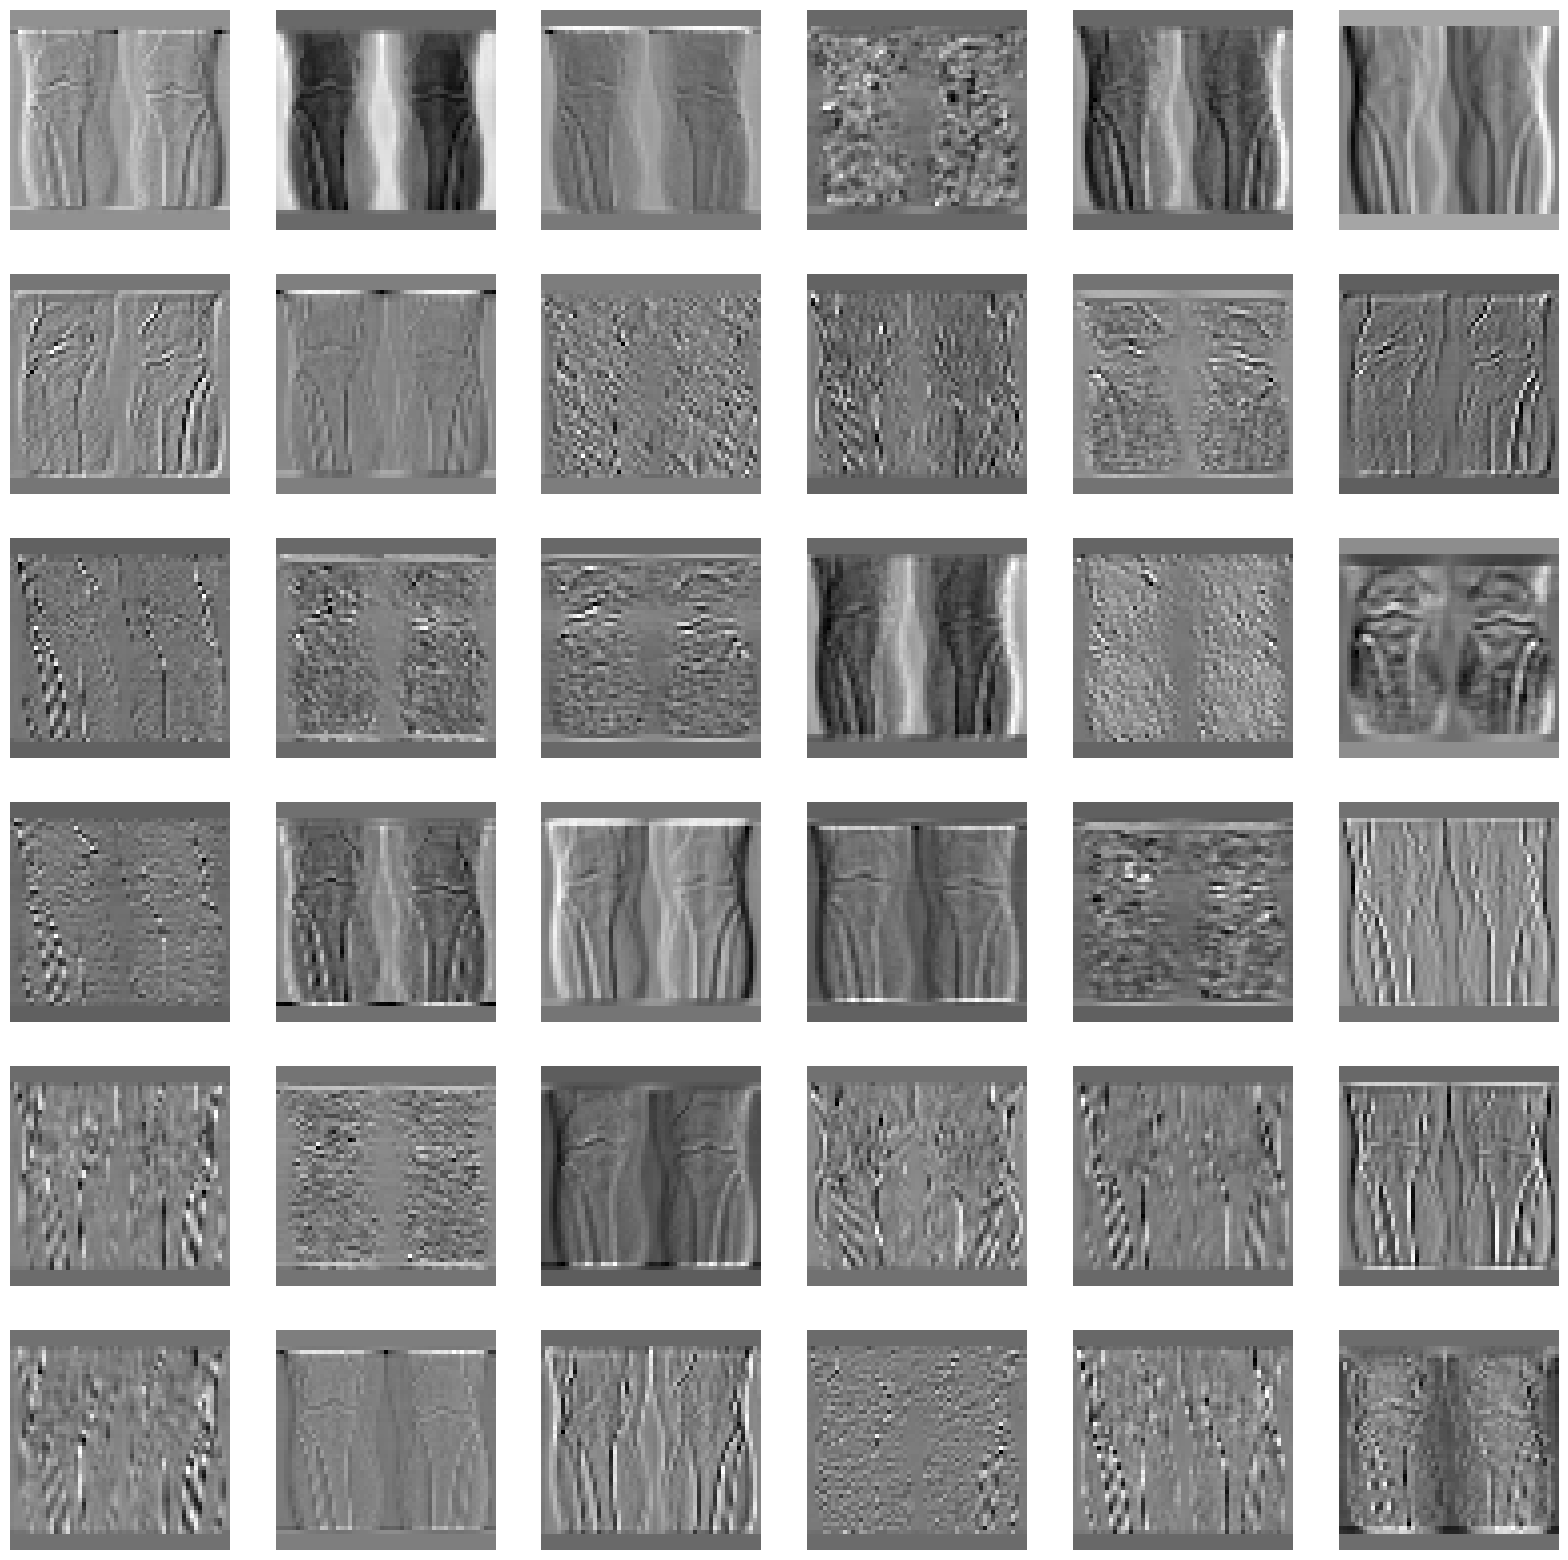

In [13]:
# Show the feature map
layer1 = model.features[0]
feature_map = layer1.forward(input)
print(layer1)
print(feature_map.shape)

# Show the feature map
feature_image = feature_map.squeeze().cpu().detach().numpy()
print(feature_image.shape)
plt.figure(figsize=(20, 20))
for i in range(36):
    plt.subplot(6, 6, i+1)
    plt.imshow(normalize(feature_image[i]), cmap='gray')
    plt.axis('off') 


In [14]:
!nvidia-smi

Sat Jun 10 03:53:17 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 515.57       Driver Version: 515.57       CUDA Version: 11.7     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA GeForce ...  Off  | 00000000:06:00.0  On |                  N/A |
| 34%   61C    P2    57W / 125W |   3337MiB /  6144MiB |     42%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [15]:
del model, alexnet_trainer, feature_map
torch.cuda.empty_cache()

In [16]:
!nvidia-smi

Sat Jun 10 03:53:17 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 515.57       Driver Version: 515.57       CUDA Version: 11.7     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA GeForce ...  Off  | 00000000:06:00.0  On |                  N/A |
| 34%   61C    P2    59W / 125W |   2047MiB /  6144MiB |     42%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

### VGG19
- https://pytorch.org/vision/0.11/models.html?highlight=vgg19#torchvision.models.vgg19

/home/yancheng/miniconda3/envs/DL/lib/python3.8/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/yancheng/miniconda3/envs/DL/lib/python3.8/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG19_Weights.IMAGENET1K_V1`. You can also use `weights=VGG19_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


--------------------Epoch 1--------------------
Train_accuracy: 64.04% | Train_loss: 208.9148
--------------------Epoch 2--------------------
Train_accuracy: 64.53% | Train_loss: 196.6580
--------------------Epoch 3--------------------
Train_accuracy: 64.53% | Train_loss: 186.5914
--------------------Epoch 4--------------------
Train_accuracy: 64.53% | Train_loss: 184.5224
--------------------Epoch 5--------------------
Train_accuracy: 64.53% | Train_loss: 181.5920
--------------------Epoch 6--------------------
Train_accuracy: 64.53% | Train_loss: 184.2840
--------------------Epoch 7--------------------
Train_accuracy: 64.53% | Train_loss: 188.4129
--------------------Epoch 8--------------------
Train_accuracy: 64.53% | Train_loss: 182.4642
--------------------Epoch 9--------------------
Train_accuracy: 64.53% | Train_loss: 182.8482
--------------------Epoch 10--------------------
Train_accuracy: 64.53% | Train_loss: 182.4049


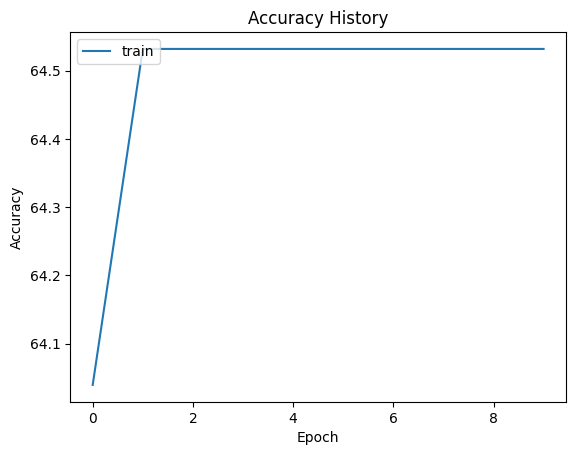

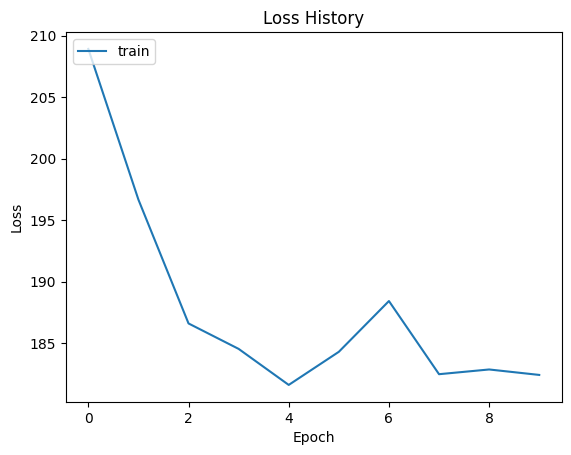

Accuracy on the test images: 63.89%
Inference time: 321.7640 milliseconds


In [17]:
model = vgg19(pretrained=True).to(device)
model.classifier[6] = torch.nn.Linear(4096, 3).to(device)
vgg19_trainer = trainer(model, train_loader, test_loader, EPOCHS, 1e-4)
vgg19_trainer.train()
vgg19_trainer.predict()

In [18]:
model

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padd

Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
torch.Size([1, 64, 224, 224])
(64, 224, 224)


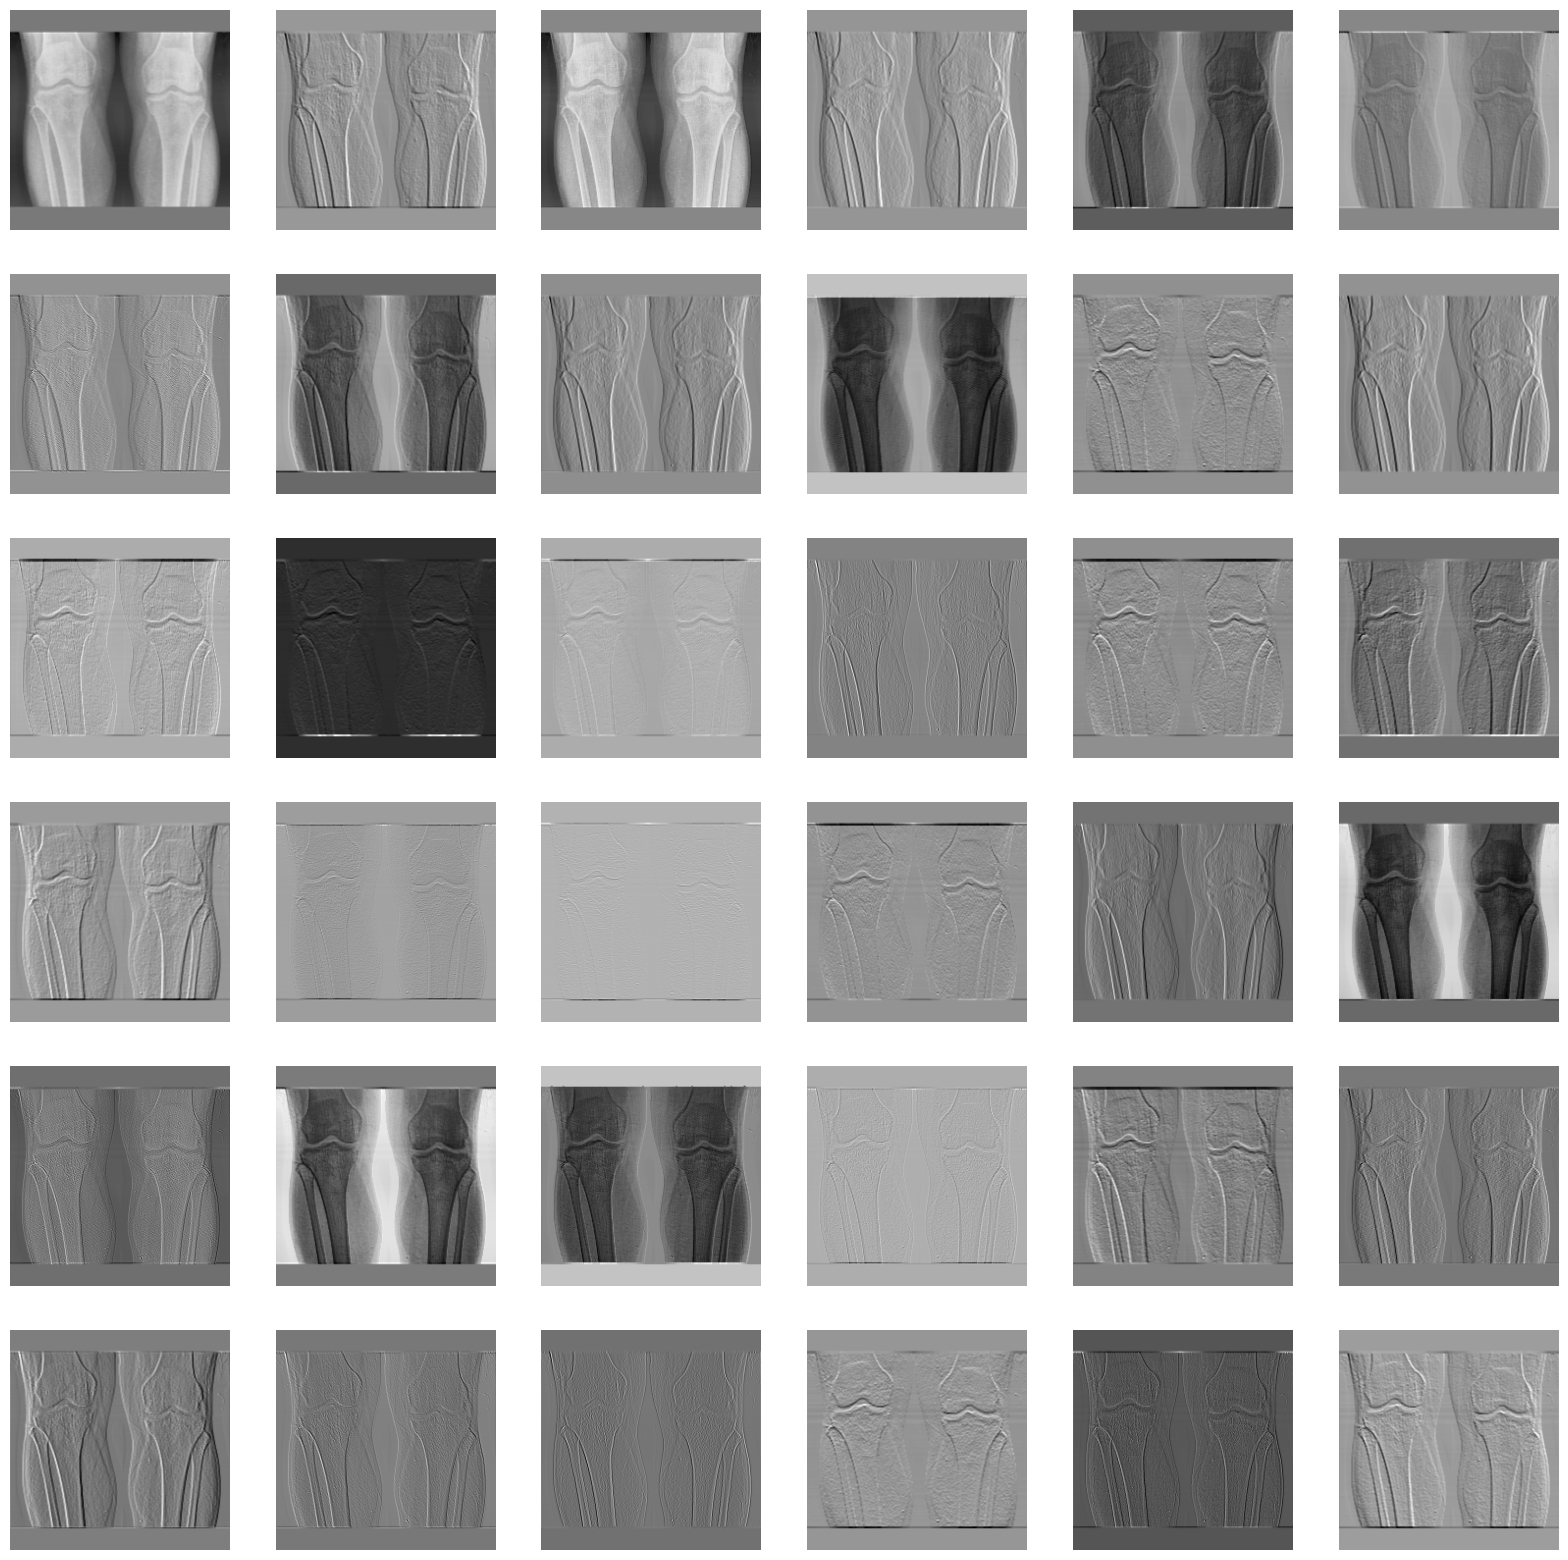

In [19]:
# Show the feature map
layer1 = model.features[0]
feature_map = layer1.forward(input)
print(layer1)
print(feature_map.shape)

# Show the feature map
feature_image = feature_map.squeeze().cpu().detach().numpy()
print(feature_image.shape)
plt.figure(figsize=(20, 20))
for i in range(36):
    plt.subplot(6, 6, i+1)
    plt.imshow(normalize(feature_image[i]), cmap='gray')
    plt.axis('off') 

In [20]:
!nvidia-smi

Sat Jun 10 03:55:52 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 515.57       Driver Version: 515.57       CUDA Version: 11.7     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA GeForce ...  Off  | 00000000:06:00.0  On |                  N/A |
| 45%   68C    P2    56W / 125W |   5675MiB /  6144MiB |     54%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [21]:
del model, vgg19_trainer, feature_map
torch.cuda.empty_cache()

In [22]:
!nvidia-smi

Sat Jun 10 03:55:52 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 515.57       Driver Version: 515.57       CUDA Version: 11.7     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA GeForce ...  Off  | 00000000:06:00.0  On |                  N/A |
| 45%   68C    P2    61W / 125W |   3111MiB /  6144MiB |     17%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

### resnet50
- https://pytorch.org/vision/0.11/models.html?highlight=alexnet#torchvision.models.alexnet

/home/yancheng/miniconda3/envs/DL/lib/python3.8/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/yancheng/miniconda3/envs/DL/lib/python3.8/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


--------------------Epoch 1--------------------
Train_accuracy: 64.53% | Train_loss: 195.9328
--------------------Epoch 2--------------------
Train_accuracy: 64.53% | Train_loss: 171.6792
--------------------Epoch 3--------------------
Train_accuracy: 64.53% | Train_loss: 160.8763
--------------------Epoch 4--------------------
Train_accuracy: 64.53% | Train_loss: 152.9685
--------------------Epoch 5--------------------
Train_accuracy: 64.53% | Train_loss: 146.9535
--------------------Epoch 6--------------------
Train_accuracy: 64.53% | Train_loss: 140.9339
--------------------Epoch 7--------------------
Train_accuracy: 64.53% | Train_loss: 135.9357
--------------------Epoch 8--------------------
Train_accuracy: 64.53% | Train_loss: 131.3558
--------------------Epoch 9--------------------
Train_accuracy: 65.02% | Train_loss: 127.2276
--------------------Epoch 10--------------------
Train_accuracy: 65.52% | Train_loss: 122.5959


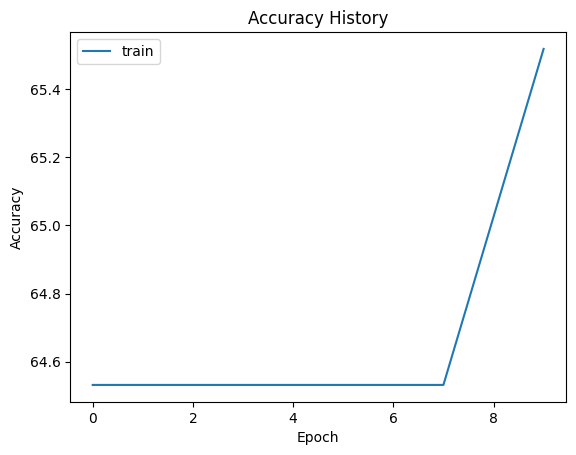

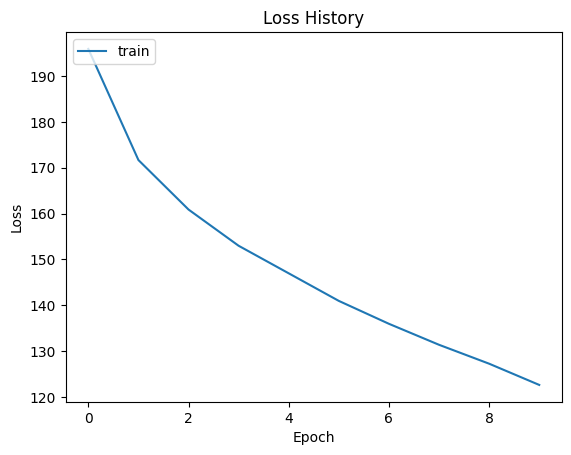

Accuracy on the test images: 63.89%
Inference time: 107.4682 milliseconds


In [23]:
model = resnet50(pretrained=True).to(device)
num_features = model.fc.in_features
model.fc = torch.nn.Linear(num_features, 3).to(device)

resnet_trainer = trainer(model, train_loader, test_loader, EPOCHS, 5e-6)
resnet_trainer.train()
resnet_trainer.predict()

In [24]:
model

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
torch.Size([1, 64, 56, 56])
(64, 56, 56)


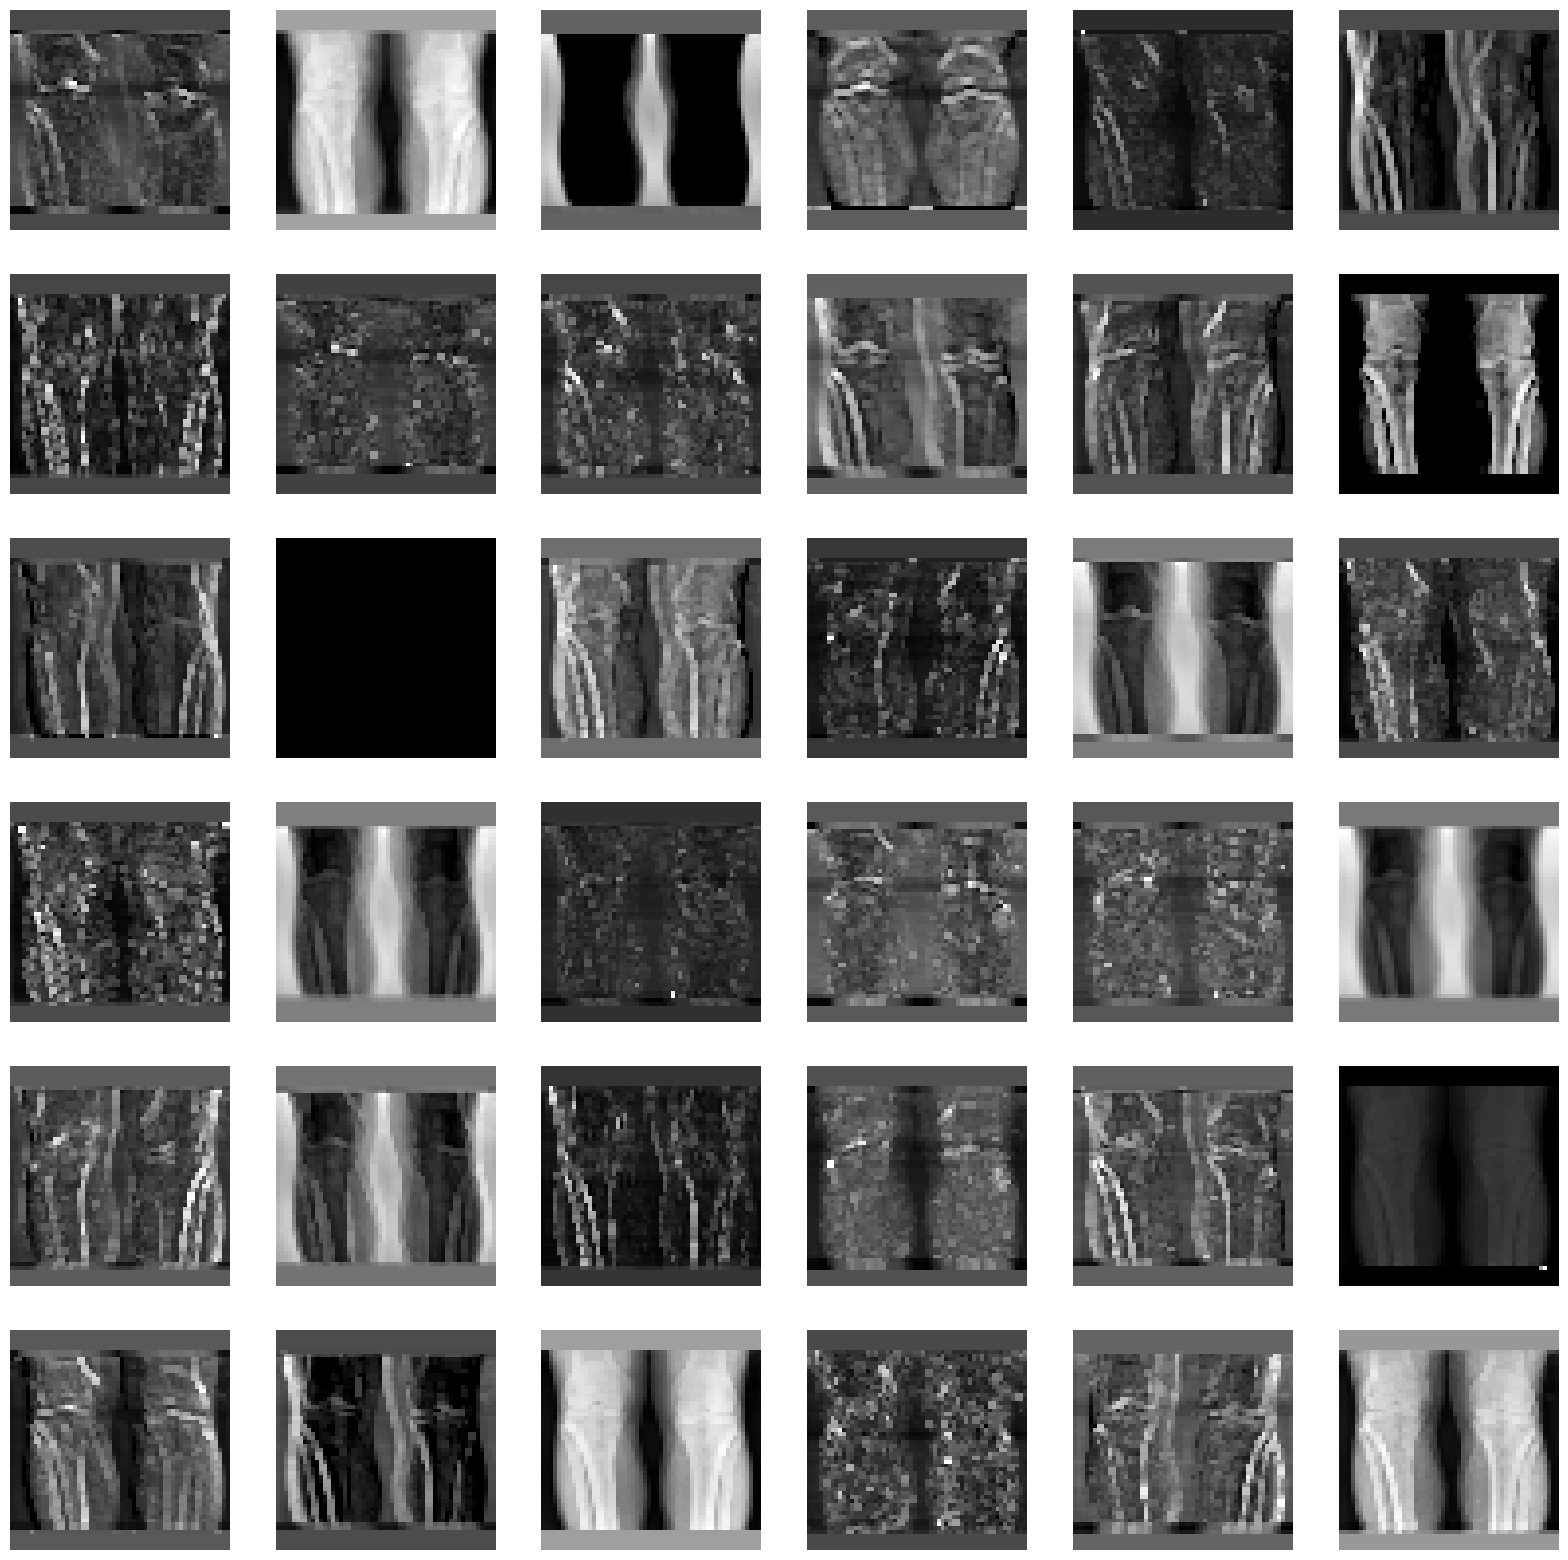

In [25]:
# show the feature map

# layer1 = model.conv1
feature_map = model.conv1.forward(input)
feature_map = model.bn1.forward(feature_map)
feature_map = model.relu.forward(feature_map)
feature_map = model.maxpool.forward(feature_map)
print(layer1)
print(feature_map.shape)

# Show the feature map
feature_image = feature_map.squeeze().cpu().detach().numpy()
print(feature_image.shape)
plt.figure(figsize=(20, 20))
for i in range(36):
    plt.subplot(6, 6, i+1)
    plt.imshow(normalize(feature_image[i]), cmap='gray')
    plt.axis('off') 

In [26]:
!nvidia-smi

Sat Jun 10 03:56:49 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 515.57       Driver Version: 515.57       CUDA Version: 11.7     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA GeForce ...  Off  | 00000000:06:00.0  On |                  N/A |
| 46%   68C    P2    56W / 125W |   4300MiB /  6144MiB |     53%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [27]:
del model, resnet_trainer, feature_map
torch.cuda.empty_cache()


In [28]:
!nvidia-smi

Sat Jun 10 03:56:50 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 515.57       Driver Version: 515.57       CUDA Version: 11.7     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA GeForce ...  Off  | 00000000:06:00.0  On |                  N/A |
| 46%   68C    P2    59W / 125W |   3314MiB /  6144MiB |     53%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

### inception_v4
- https://huggingface.co/docs/timm/models/inception-v4

--------------------Epoch 1--------------------
Train_accuracy: 49.26% | Train_loss: 213.1432
--------------------Epoch 2--------------------
Train_accuracy: 64.53% | Train_loss: 190.7033
--------------------Epoch 3--------------------
Train_accuracy: 64.53% | Train_loss: 178.5884
--------------------Epoch 4--------------------
Train_accuracy: 64.53% | Train_loss: 171.8728
--------------------Epoch 5--------------------
Train_accuracy: 64.53% | Train_loss: 165.5371
--------------------Epoch 6--------------------
Train_accuracy: 64.53% | Train_loss: 161.7868
--------------------Epoch 7--------------------
Train_accuracy: 64.53% | Train_loss: 155.0183
--------------------Epoch 8--------------------
Train_accuracy: 64.53% | Train_loss: 149.5819
--------------------Epoch 9--------------------
Train_accuracy: 64.53% | Train_loss: 146.2882
--------------------Epoch 10--------------------
Train_accuracy: 64.53% | Train_loss: 144.3081


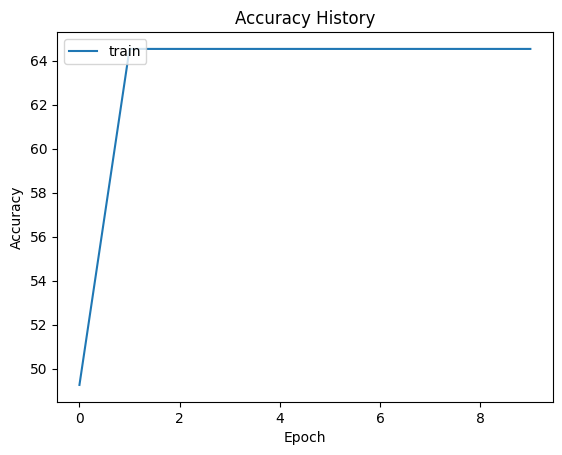

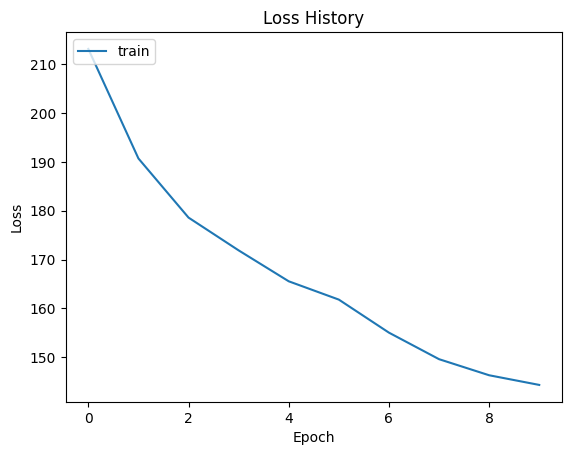

Accuracy on the test images: 63.89%
Inference time: 154.9872 milliseconds


In [29]:
model = timm.create_model('inception_v4', pretrained=True, num_classes=3).to(device)
inception_v4_trainer = trainer(model, train_loader, test_loader, EPOCHS, 5e-6)
inception_v4_trainer.train()
inception_v4_trainer.predict()

ConvNormAct(
  (conv): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), bias=False)
  (bn): BatchNormAct2d(
    32, eps=0.001, momentum=0.1, affine=True, track_running_stats=True
    (drop): Identity()
    (act): ReLU(inplace=True)
  )
)
torch.Size([1, 32, 111, 111])
(32, 111, 111)


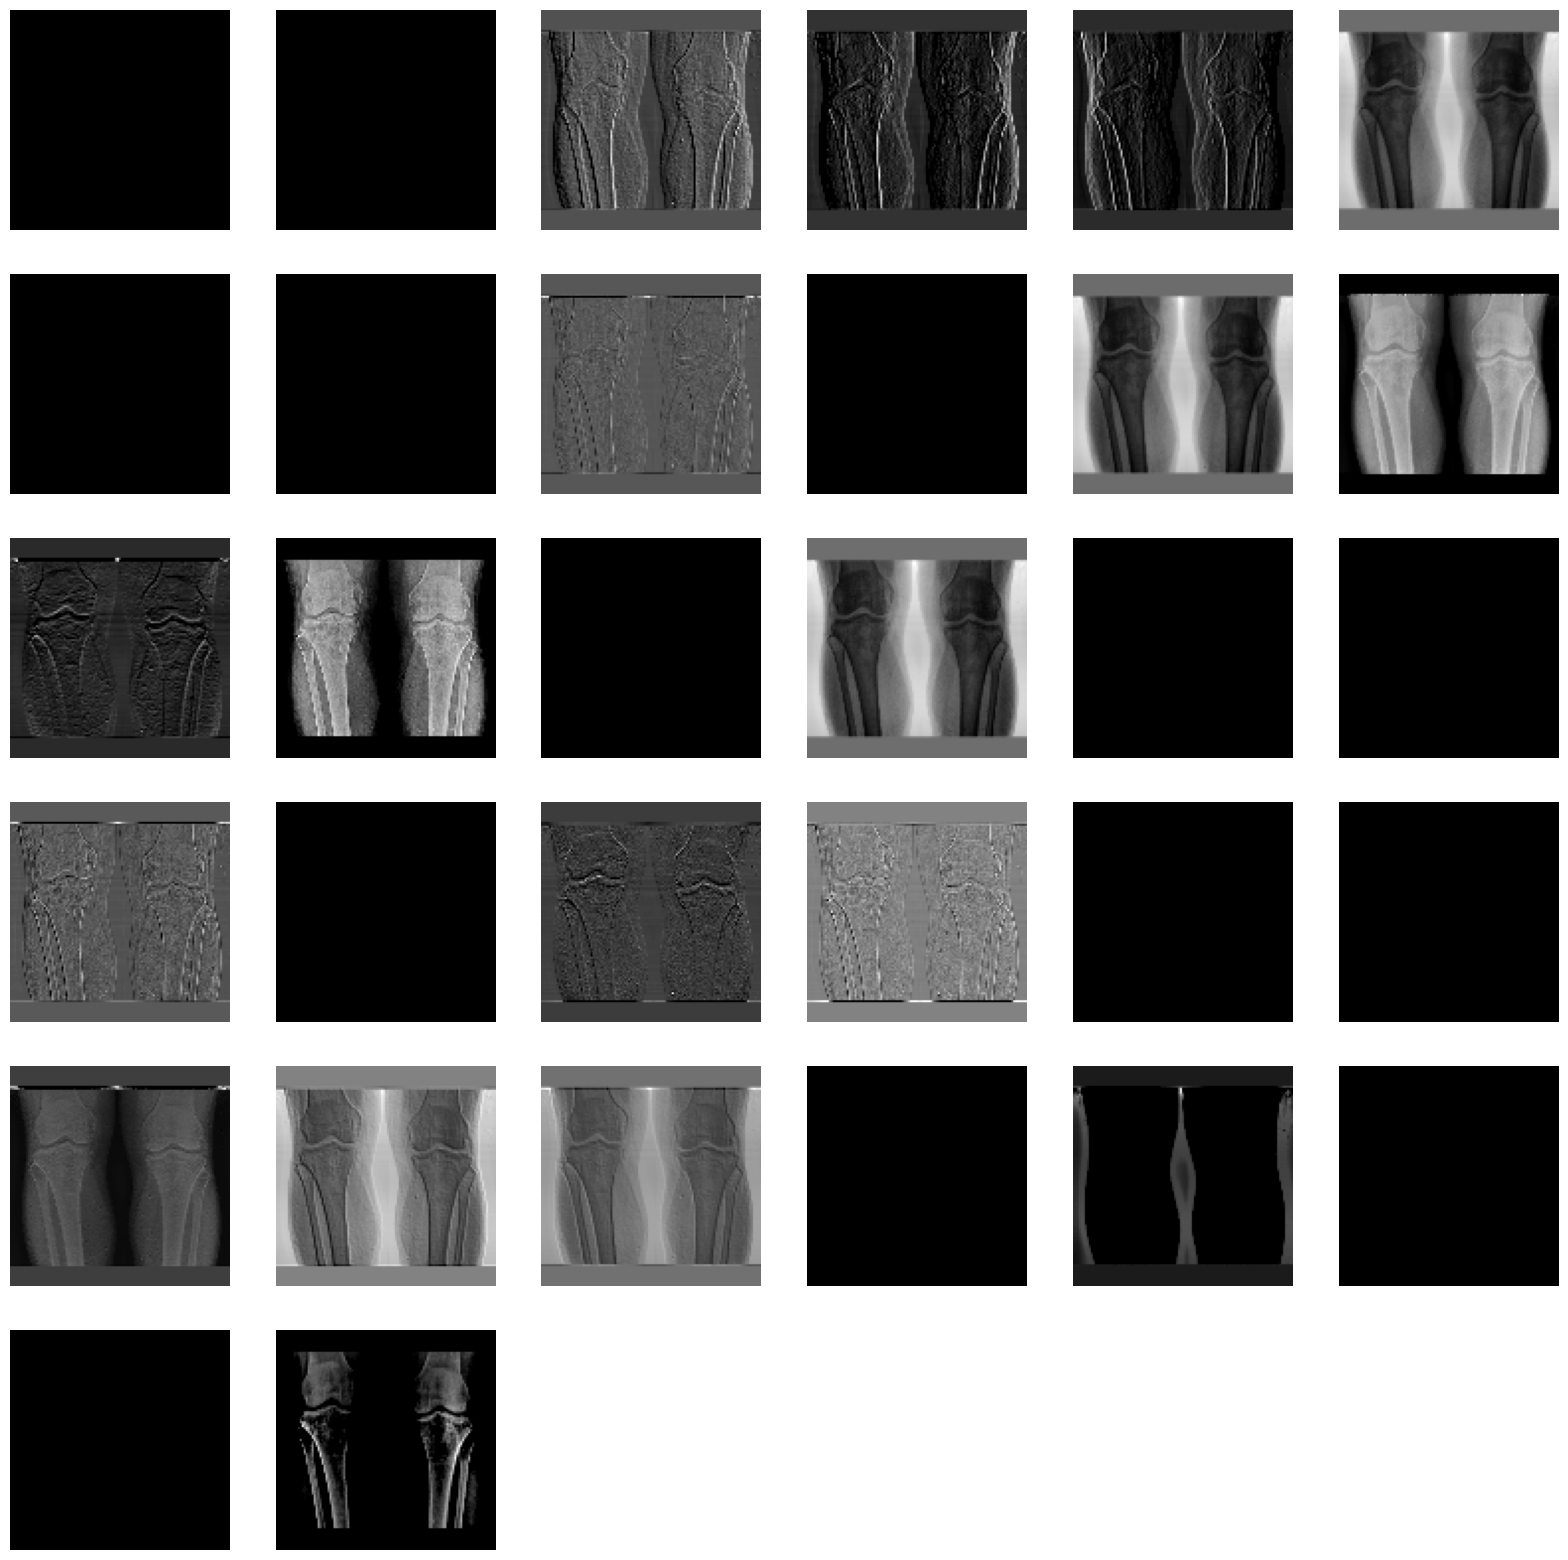

In [30]:
# Show the feature map
layer1 = model.features[0]
feature_map = layer1.forward(input)
print(layer1)
print(feature_map.shape)

# Show the feature map
feature_image = feature_map.squeeze().cpu().detach().numpy()
print(feature_image.shape)
plt.figure(figsize=(20, 20))
for i in range(32):
    plt.subplot(6, 6, i+1)
    plt.imshow(normalize(feature_image[i]), cmap='gray')
    plt.axis('off') 


In [31]:
!nvidia-smi

Sat Jun 10 03:58:44 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 515.57       Driver Version: 515.57       CUDA Version: 11.7     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA GeForce ...  Off  | 00000000:06:00.0  On |                  N/A |
| 46%   67C    P2    55W / 125W |   5130MiB /  6144MiB |     30%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [32]:
del model, inception_v4_trainer, feature_map
torch.cuda.empty_cache()

In [33]:
!nvidia-smi

Sat Jun 10 03:58:44 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 515.57       Driver Version: 515.57       CUDA Version: 11.7     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA GeForce ...  Off  | 00000000:06:00.0  On |                  N/A |
| 46%   67C    P2    58W / 125W |   3437MiB /  6144MiB |     30%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

### Visual Transformer

In [34]:
model = timm.create_model('vit_base_patch16_224', pretrained=True, num_classes=3).to(device)
vit_trainer = trainer(model, train_loader, test_loader, EPOCHS, 1e-4)
vit_trainer.train()
vit_trainer.predict()

--------------------Epoch 1--------------------
Train_accuracy: 54.68% | Train_loss: 266.4624


In [ ]:
model.blocks

VisionTransformer(
  (patch_embed): PatchEmbed(
    (proj): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
    (norm): Identity()
  )
  (pos_drop): Dropout(p=0.0, inplace=False)
  (patch_drop): Identity()
  (norm_pre): Identity()
  (blocks): Sequential(
    (0): Block(
      (norm1): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
      (attn): Attention(
        (qkv): Linear(in_features=768, out_features=2304, bias=True)
        (q_norm): Identity()
        (k_norm): Identity()
        (attn_drop): Dropout(p=0.0, inplace=False)
        (proj): Linear(in_features=768, out_features=768, bias=True)
        (proj_drop): Dropout(p=0.0, inplace=False)
      )
      (ls1): Identity()
      (drop_path1): Identity()
      (norm2): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
      (mlp): Mlp(
        (fc1): Linear(in_features=768, out_features=3072, bias=True)
        (act): GELU(approximate='none')
        (drop1): Dropout(p=0.0, inplace=False)
        (norm): Identity(

torch.Size([1, 3, 224, 224])
Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
torch.Size([1, 768, 14, 14])
(768, 14, 14)


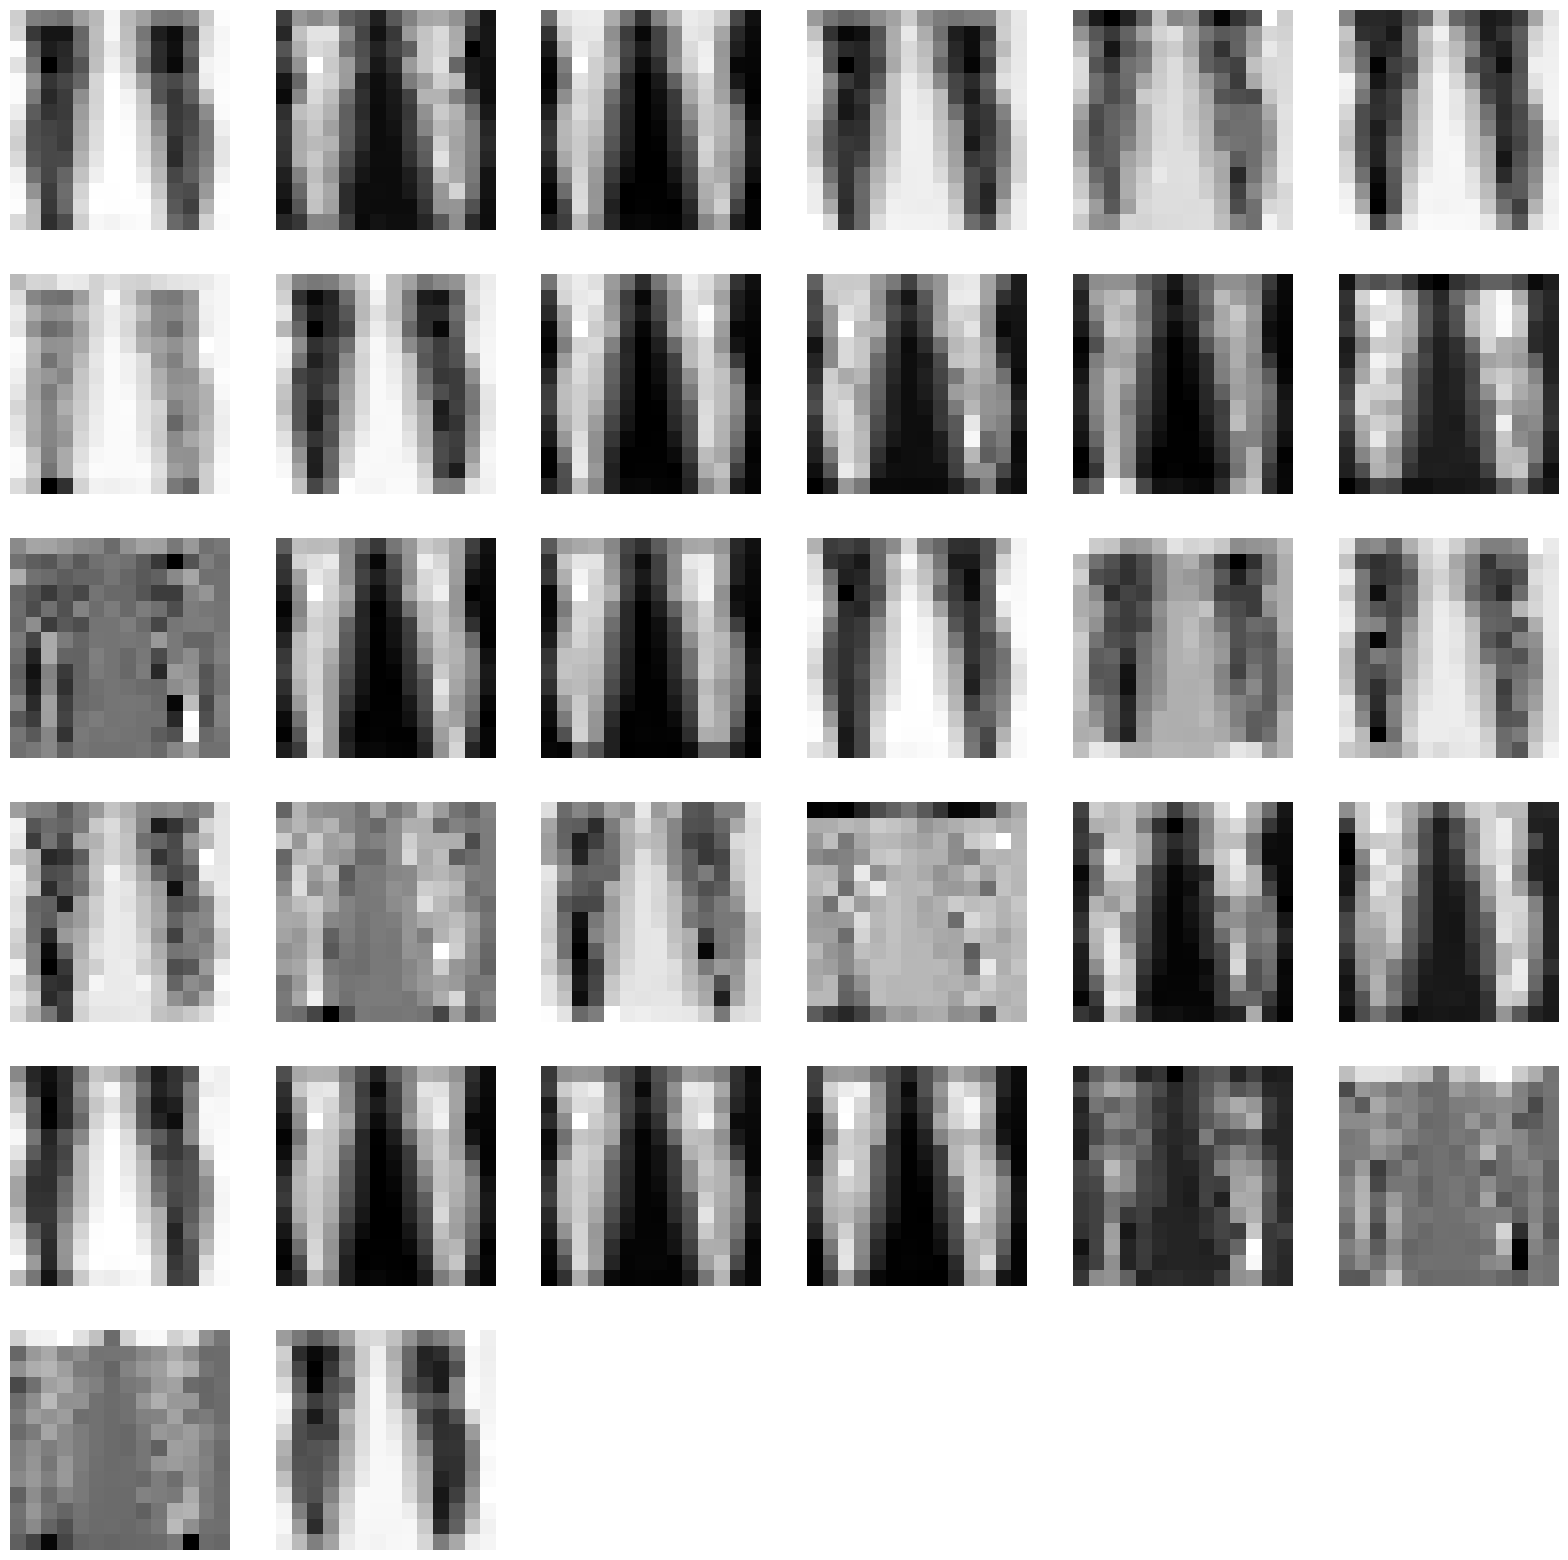

In [ ]:

# Show the feature map
layer1 = model.patch_embed.proj
feature_map = layer1.forward(input)
print(layer1)
print(feature_map.shape)

# Show the feature map
feature_image = feature_map.squeeze().cpu().detach().numpy()
print(feature_image.shape)
plt.figure(figsize=(20, 20))
for i in range(36):
    plt.subplot(6, 6, i+1)
    plt.imshow(normalize(feature_image[i]), cmap='gray')
    plt.axis('off') 

In [ ]:
!nvidia-smi

In [ ]:
del model, vit_trainer, feature_map
torch.cuda.empty_cache()

In [ ]:
!nvidia-smi

### Swin-Transformer
- https://github.com/microsoft/Swin-Transformer

/home/yancheng/miniconda3/envs/DL/lib/python3.8/site-packages/torch/functional.py:504: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at ../aten/src/ATen/native/TensorShape.cpp:3483.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


--------------------Epoch 1--------------------
Train_accuracy: 63.05% | Train_loss: 191.4681
--------------------Epoch 2--------------------
Train_accuracy: 61.58% | Train_loss: 182.4587
--------------------Epoch 3--------------------
Train_accuracy: 64.04% | Train_loss: 188.5485
--------------------Epoch 4--------------------
Train_accuracy: 64.04% | Train_loss: 188.3301
--------------------Epoch 5--------------------
Train_accuracy: 65.02% | Train_loss: 186.0477
--------------------Epoch 6--------------------
Train_accuracy: 64.53% | Train_loss: 186.1509
--------------------Epoch 7--------------------
Train_accuracy: 64.04% | Train_loss: 183.5536
--------------------Epoch 8--------------------
Train_accuracy: 64.53% | Train_loss: 185.5447
--------------------Epoch 9--------------------
Train_accuracy: 64.53% | Train_loss: 185.4314
--------------------Epoch 10--------------------
Train_accuracy: 64.53% | Train_loss: 184.5802


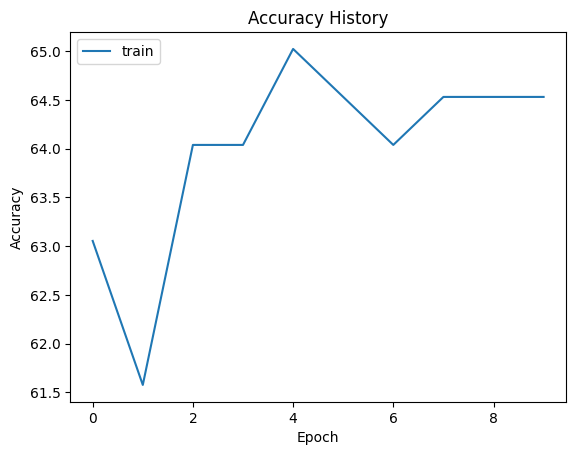

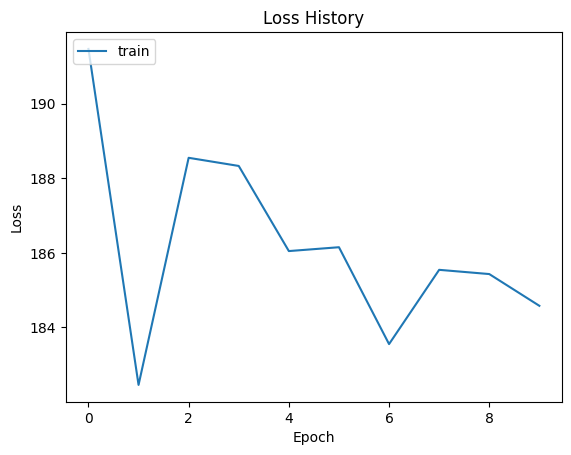

Accuracy on the test images: 63.89%
Inference time: 531.7076 milliseconds


In [ ]:
model = timm.create_model('swin_base_patch4_window7_224', pretrained=True, num_classes=3).to(device)
swin_trainer = trainer(model, train_loader, test_loader, EPOCHS, 5e-5)
swin_trainer.train()
swin_trainer.predict()

In [ ]:
model

SwinTransformer(
  (patch_embed): PatchEmbed(
    (proj): Conv2d(3, 128, kernel_size=(4, 4), stride=(4, 4))
    (norm): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
  )
  (layers): Sequential(
    (0): SwinTransformerStage(
      (downsample): Identity()
      (blocks): Sequential(
        (0): SwinTransformerBlock(
          (norm1): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
          (attn): WindowAttention(
            (qkv): Linear(in_features=128, out_features=384, bias=True)
            (attn_drop): Dropout(p=0.0, inplace=False)
            (proj): Linear(in_features=128, out_features=128, bias=True)
            (proj_drop): Dropout(p=0.0, inplace=False)
            (softmax): Softmax(dim=-1)
          )
          (drop_path): Identity()
          (norm2): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
          (mlp): Mlp(
            (fc1): Linear(in_features=128, out_features=512, bias=True)
            (act): GELU(approximate='none')
            (d

torch.Size([1, 3, 224, 224])
Conv2d(3, 128, kernel_size=(4, 4), stride=(4, 4))
torch.Size([1, 128, 56, 56])
(128, 56, 56)


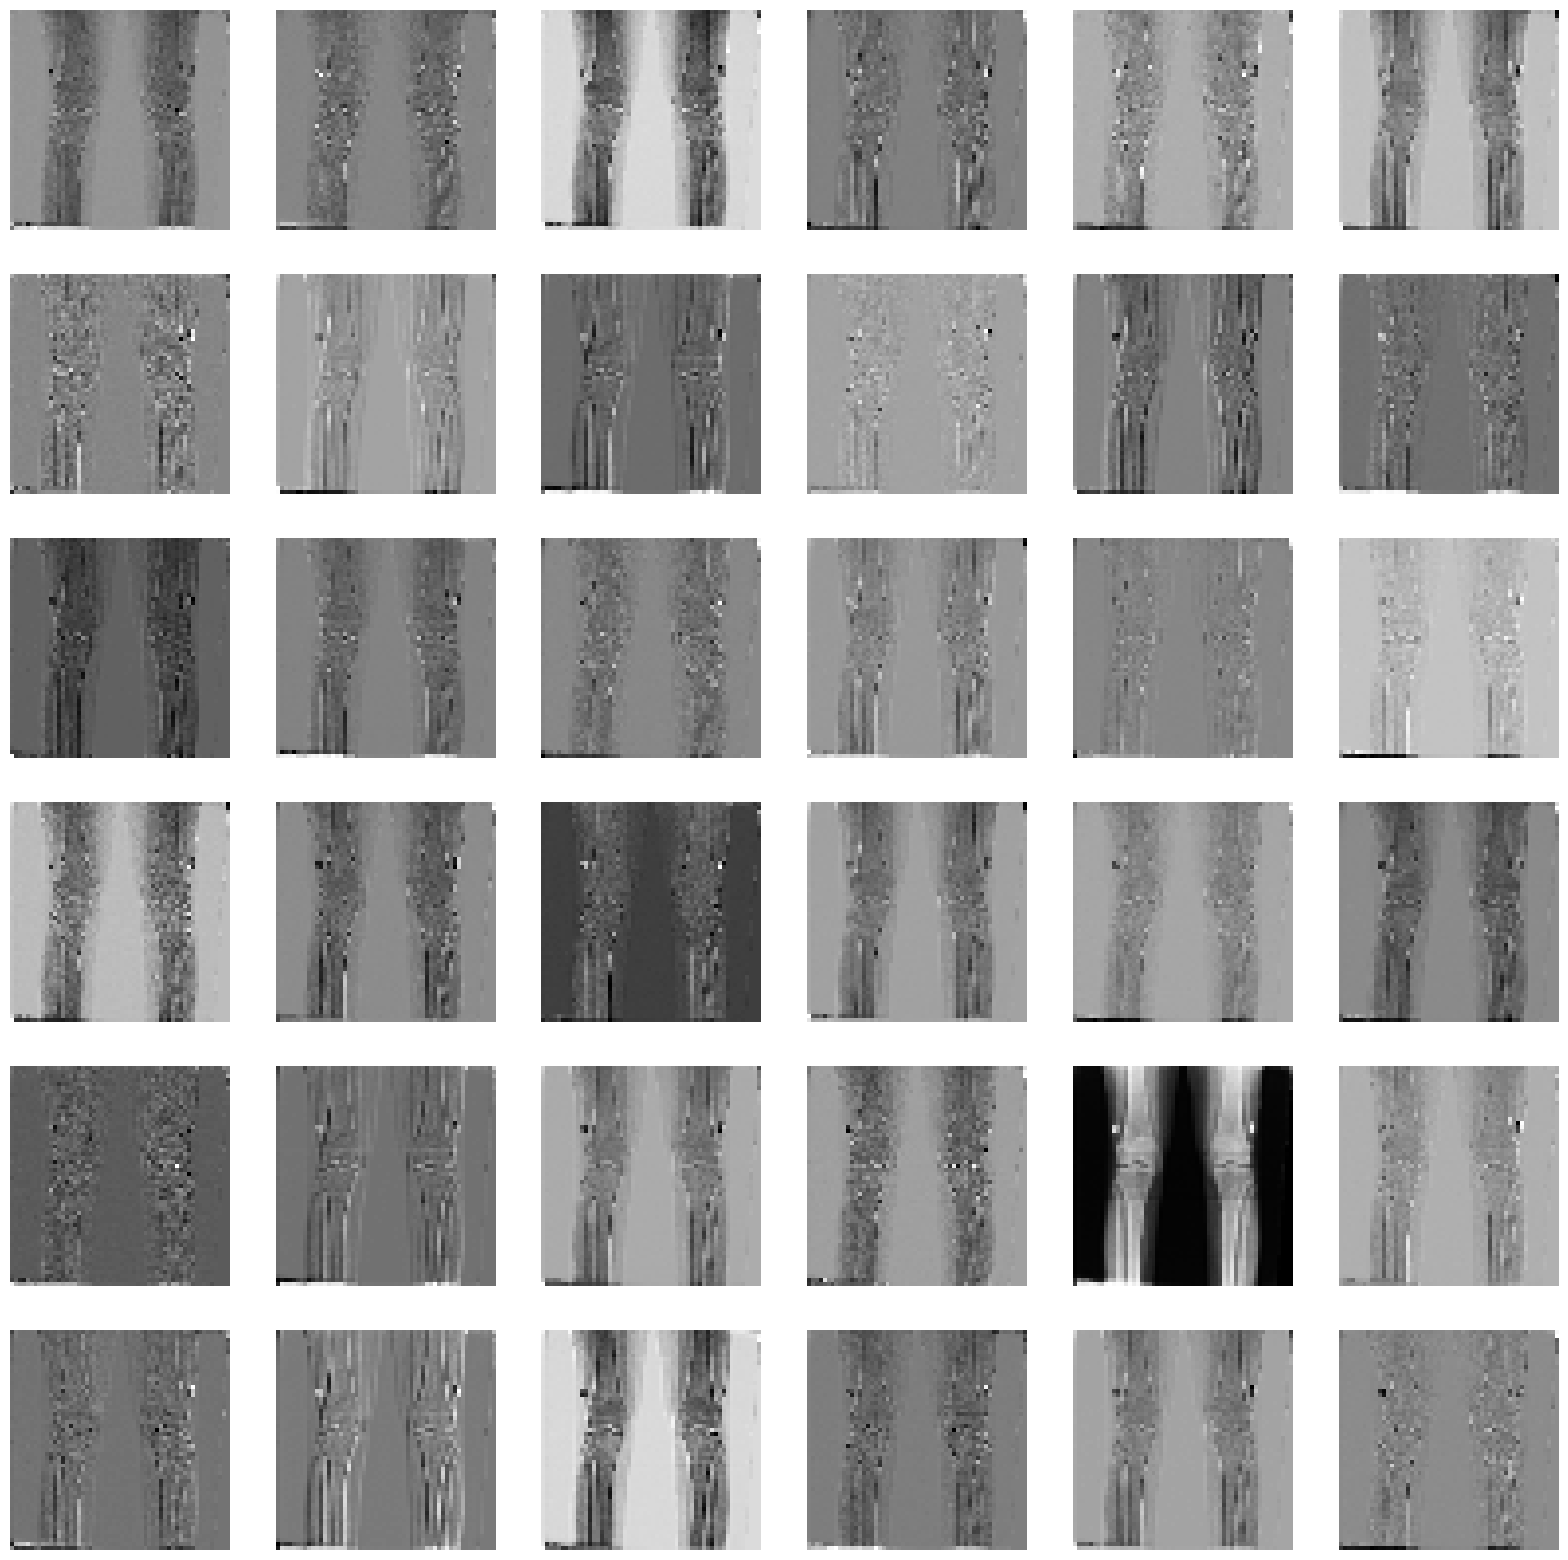

In [ ]:
# Show the feature map
layer1 = model.patch_embed.proj
feature_map = layer1.forward(input)
print(layer1)
print(feature_map.shape)

# Show the feature map
feature_image = feature_map.squeeze().cpu().detach().numpy()
print(feature_image.shape)
plt.figure(figsize=(20, 20))
for i in range(36):
    plt.subplot(6, 6, i+1)
    plt.imshow(normalize(feature_image[i]), cmap='gray')
    plt.axis('off') 

In [ ]:
!nvidia-smi

In [ ]:
del model, swin_trainer, feature_map
torch.cuda.empty_cache()

In [ ]:
!nvidia-smi